# Initialization

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, DecimalType, IntegerType
from pyspark.sql.functions import col, month, year, isnan, desc, unix_timestamp, to_timestamp, dayofmonth, hour, minute, second
from functools import reduce
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# Setting up a theme with Seaborn
sns.set_theme(style="whitegrid")

# Adjusting font scale for better readability
sns.set_context("notebook", font_scale=1.2)

In [17]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Yellow Taxi EDA") \
    .getOrCreate()


# I ran this notebook successfully using 4 cores and 8GB per node in the jupyter session setup. 
# Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting.
# spark = SparkSession.builder \
#     .config("spark.driver.memory", "8g") \
# 	.config("spark.executor.memory", "4g") \
#     .config('spark.executor.instances', 6) \
# 	.appName("Yellow Taxi EDA") \
# 	.getOrCreate()

In [18]:
spark

# Importing Data

In [39]:
# base_path = '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-{:02d}.parquet'

paths = ['hradhakrishnan/yellow_taxi_data/yellow_tripdata_2023-01.parquet', 'hradhakrishnan/yellow_taxi_data/yellow_tripdata_2023-02.parquet']

# for mo in range(1, 7):  # This loops from 1 to 12
#     path = base_path.format(mo)  # Formats the month with leading zero if necessary
#     paths.append(path)

In [40]:
# Function to load and cast a single Parquet file
def load_and_cast(filepath):
    df = spark.read.parquet(filepath)
    df = df.withColumn("VendorID", col("VendorID").cast(IntegerType()))
    return df

# Load, cast, and accumulate all DataFrames
dataframes = [load_and_cast(path) for path in paths]
df = reduce(lambda df1, df2: df1.unionByName(df2), dataframes)

# Show the DataFrame
df.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [41]:
df.count()

5980721

In [42]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# EDA 

In [43]:
# Summary statistics for numeric fields
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
df.select(numeric_cols).describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|   passenger_count|     trip_distance|       fare_amount|       tip_amount|      total_amount|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|           5832161|           5980721|           5980721|          5980721|           5980721|
|   mean|1.3578207117396108|3.8574354630484002|18.295598793189132| 3.37616698388113|26.960991094487895|
| stddev|0.8927377984327337| 258.9361158969996|17.657792913093825|3.832283059004118|22.007135702165705|
|    min|               0.0|               0.0|            -900.0|           -96.22|           -757.55|
|    max|               9.0|         335004.33|            2203.1|            482.9|            2208.1|
+-------+------------------+------------------+------------------+-----------------+------------------+



In [44]:
# Dictionary to hold the column names and their corresponding counts of missing values
missing_counts = {}

# Calculate missing values for each column, taking data type into consideration
for col_name in df.columns:
    if df.schema[col_name].dataType == "DoubleType" or df.schema[col_name].dataType == "FloatType":
        missing_count = df.filter((col(col_name).isNull()) | (isnan(col_name))).count()
    else:
        missing_count = df.filter(col(col_name).isNull()).count()
    missing_counts[col_name] = missing_count

# Convert the dictionary to a Pandas DataFrame for displaying as a table
missing_counts_df = pd.DataFrame(list(missing_counts.items()), columns=['Column Name', 'Missing Values'])

# Display the DataFrame as a table
print(missing_counts_df)

              Column Name  Missing Values
0                VendorID               0
1    tpep_pickup_datetime               0
2   tpep_dropoff_datetime               0
3         passenger_count          148560
4           trip_distance               0
5              RatecodeID          148560
6      store_and_fwd_flag          148560
7            PULocationID               0
8            DOLocationID               0
9            payment_type               0
10            fare_amount               0
11                  extra               0
12                mta_tax               0
13             tip_amount               0
14           tolls_amount               0
15  improvement_surcharge               0
16           total_amount               0
17   congestion_surcharge          148560
18            airport_fee          148560


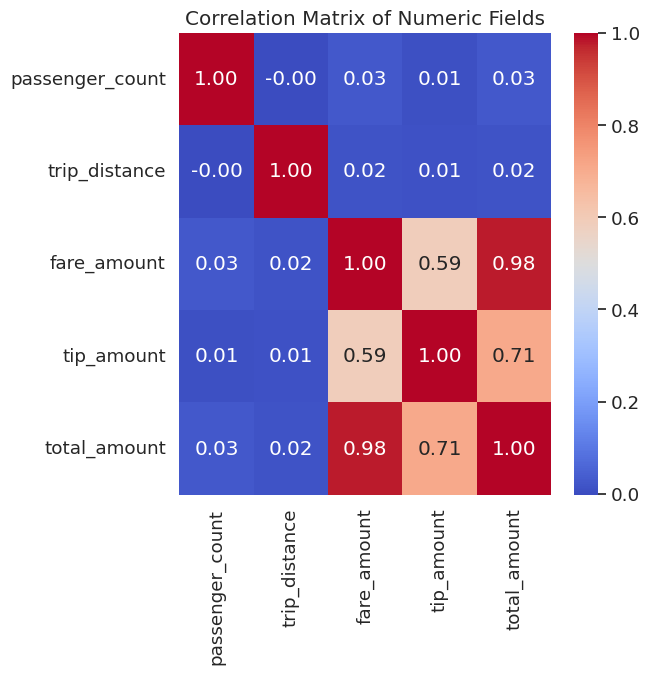

In [45]:
correlation_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        corr_value = df.stat.corr(col1, col2)
        correlation_matrix.loc[col1, col2] = corr_value

# Convert entries from object to float for plotting
correlation_matrix = correlation_matrix.astype(float)

# Plotting the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Fields')
plt.show()

In [46]:
# Most common values for categorical fields
categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type']
for col_name in categorical_cols:
    df.groupBy(col_name).count().orderBy(desc("count")).show()

+--------+-------+
|VendorID|  count|
+--------+-------+
|       2|4364316|
|       1|1615204|
|       6|   1201|
+--------+-------+

+----------+-------+
|RatecodeID|  count|
+----------+-------+
|       1.0|5537989|
|       2.0| 213434|
|      NULL| 148560|
|       5.0|  28166|
|      99.0|  26143|
|       3.0|  17722|
|       4.0|   8694|
|       6.0|     13|
+----------+-------+

+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 N|5795587|
|              NULL| 148560|
|                 Y|  36574|
+------------------+-------+

+------------+------+
|PULocationID| count|
+------------+------+
|         132|292124|
|         237|283020|
|         161|270755|
|         236|264648|
|         186|213803|
|         162|207241|
|         230|196459|
|         142|193173|
|         138|173693|
|         170|173351|
|         163|168874|
|         239|168559|
|          48|163045|
|         234|162537|
|         141|154956|
|          79

In [47]:
# Sampling a fraction of the data for visualization
sampled_df = df.sample(fraction=0.15, withReplacement=False)

In [48]:
def filter_quantile_range(df, col_names, lower_quantile=0.01, upper_quantile=0.99):
    """
    Filter data in the DataFrame based on the specified quantile range for given columns.

    Parameters:
        df (DataFrame): The input DataFrame to filter.
        col_names (list): List of column names to filter on.
        lower_quantile (float): The lower quantile bound (e.g., 0.1 for the 10th percentile).
        upper_quantile (float): The upper quantile bound (e.g., 0.9 for the 90th percentile).

    Returns:
        DataFrame: The filtered DataFrame within the specified quantile range.
    """
    # Initialize an empty list to store the filter conditions
    conditions = []
    
    for column_name in col_names:
        # Get the quantile bounds for the column
        lower_bound, upper_bound = df.approxQuantile(column_name, [lower_quantile, upper_quantile], 0.01)
        
        # Create a condition to filter data within the quantile range for this column
        condition = (col(column_name) >= lower_bound) & (col(column_name) <= upper_bound)
        conditions.append(condition)
    
    # Combine all the conditions using AND (every column must meet its own condition)
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition &= condition
    
    # Filter the DataFrame based on the combined condition
    filtered_df = df.filter(combined_condition)
    
    return filtered_df

# Total Amount

In [190]:
filtered_df = filter_quantile_range(sampled_df, ["total_amount", "tip_amount"], lower_quantile=0.05, upper_quantile=0.95)

In [191]:
pandas_df = filtered_df.select("total_amount", "tip_amount").toPandas()

In [193]:
cleaneddf = pandas_df[(pandas_df['total_amount']>0) & (pandas_df['tip_amount']>0) & (pandas_df['tip_amount']<12) & (pandas_df['total_amount']<60)]

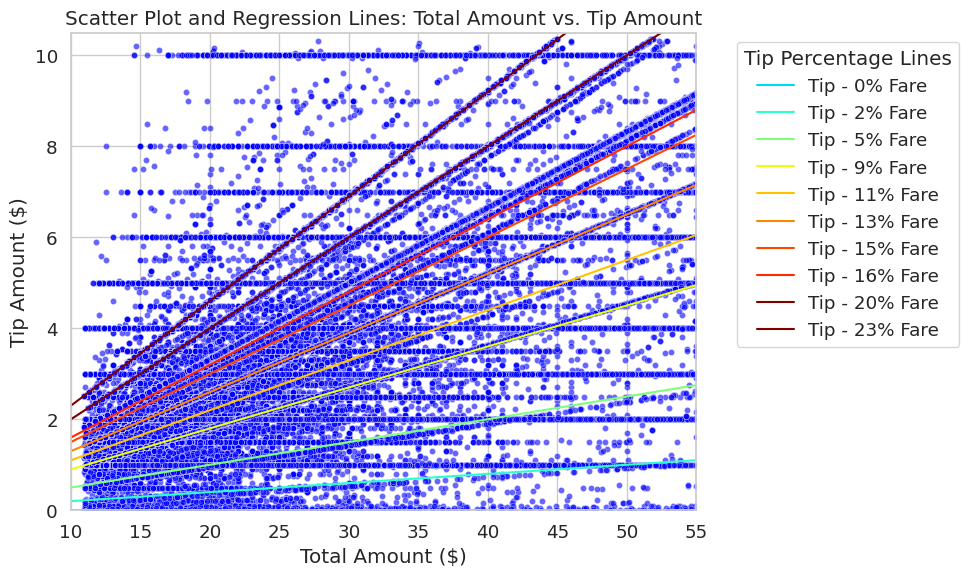

In [222]:
slopes = [0,2,5,9,11,13,15, 16,20, 23]
x_val = np.linspace(0, 60, 100)  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_amount', y='tip_amount', data=cleaneddf, color='blue', alpha=0.6, s=20)

for slope in slopes:
    y_values = slope * x_val * 0.01
    plt.plot(x_val, y_values, label=f'Tip - {slope}% Fare', color=plt.cm.jet((slope+10) / 30)) 

plt.title('Scatter Plot and Regression Lines: Total Amount vs. Tip Amount')
plt.xlabel('Total Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.legend(title='Tip Percentage Lines', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.ylim([0,10.5])
plt.xlim([10,55])
plt.tight_layout()
plt.show()

## 1. Fare amount vs Tip Amount

In [227]:
filtered_df = filter_quantile_range(sampled_df, ["fare_amount", "tip_amount"], lower_quantile=0.05, upper_quantile=0.95)

In [228]:
# Converting Spark DataFrame to Pandas DataFrame
pandas_df = filtered_df.select("fare_amount", "tip_amount").toPandas()

In [232]:
cleaneddf = pandas_df[(pandas_df['fare_amount']>0) & (pandas_df['tip_amount']>0) & (pandas_df['tip_amount']<12) & (pandas_df['fare_amount']<60)]

In [233]:
filtered_df.groupBy("tip_amount").count().orderBy("count", ascending=False).show(10)

+----------+------+
|tip_amount| count|
+----------+------+
|       0.0|165096|
|       2.0| 43415|
|       1.0| 36461|
|       3.0| 22073|
|       2.8| 11453|
|       5.0| 10261|
|       3.5| 10255|
|       4.0|  9637|
|       1.5|  9434|
|       2.1|  9180|
+----------+------+
only showing top 10 rows



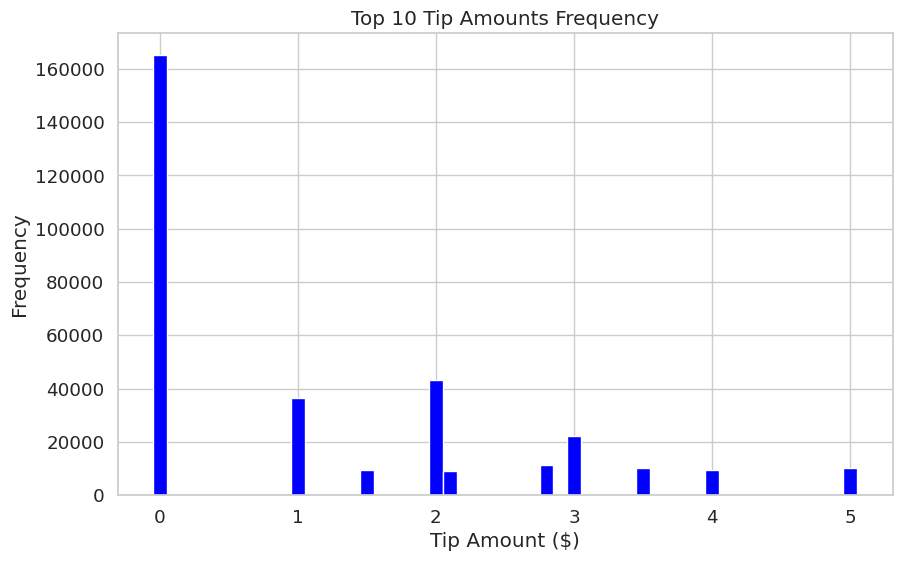

In [234]:
# Harin - tip amount by freq
tip_counts_df = filtered_df.groupBy("tip_amount").count().orderBy("count", ascending=False).limit(10)

tip_amounts, counts = zip(*tip_counts_df.rdd.map(lambda row: (row['tip_amount'], row['count'])).collect())

plt.figure(figsize=(10, 6))
plt.bar(tip_amounts, counts, color='blue', width = 0.1)
plt.title('Top 10 Tip Amounts Frequency')
plt.xlabel('Tip Amount ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [235]:
# plt.figure(figsize=(10, 6))
# sns.lmplot(x='fare_amount', y='tip_amount', data=cleaneddf, )
# plt.title('LM Plot of Fare Amount vs. Tip Amount')
# plt.xlabel('Fare Amount ($)')
# plt.ylabel('Tip Amount ($)')
# plt.show()

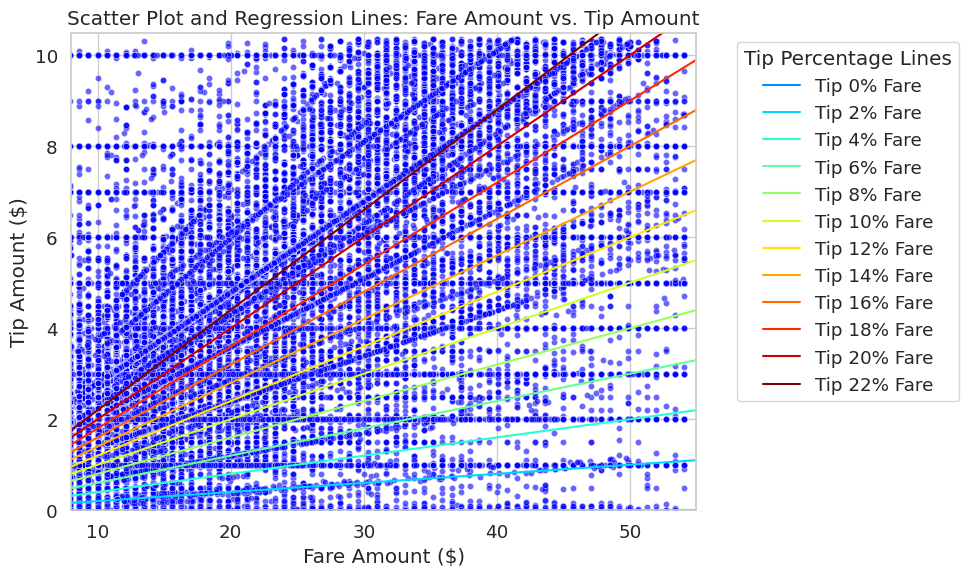

In [237]:
#Harin - Assumed const Tip % -turns out it wasn't, still not sure why there's a pattern
#intercept can account for taxes - maybe
slopes = np.arange(0, 24, 2)  
x_val = np.linspace(0, 60, 100)  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=cleaneddf, color='blue', alpha=0.6, s=20)

for slope in slopes:
    y_values = slope * x_val * 0.01
    plt.plot(x_val, y_values, label=f'Tip {slope}% Fare', color=plt.cm.jet((slope+8) / 30)) 
plt.title('Scatter Plot and Regression Lines: Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.legend(title='Tip Percentage Lines', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.ylim([0,10.5])
plt.xlim([8,55])
plt.tight_layout()
plt.show()

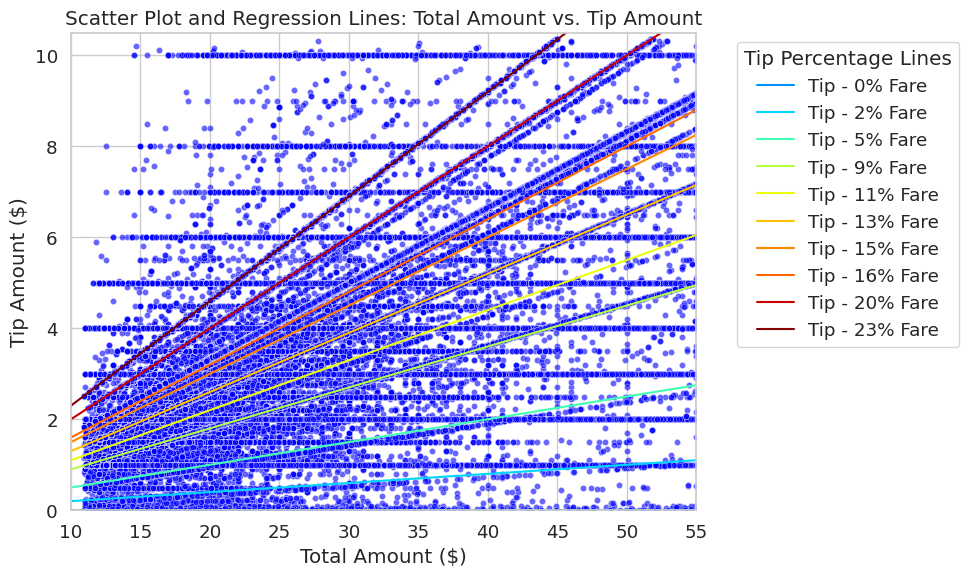

In [224]:
# seems ther's a correlation between tip and total amount, not fare amount

slopes = [0,2,5,9,11,13,15, 16,20, 23]
x_val = np.linspace(0, 60, 100)  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_amount', y='tip_amount', data=cleaneddf, color='blue', alpha=0.6, s=20)

for slope in slopes:
    y_values = slope * x_val * 0.01
    plt.plot(x_val, y_values, label=f'Tip - {slope}% Fare', color=plt.cm.jet((slope+8) / 30)) 

plt.title('Scatter Plot and Regression Lines: Total Amount vs. Tip Amount')
plt.xlabel('Total Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.legend(title='Tip Percentage Lines', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.ylim([0,10.5])
plt.xlim([10,55])
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


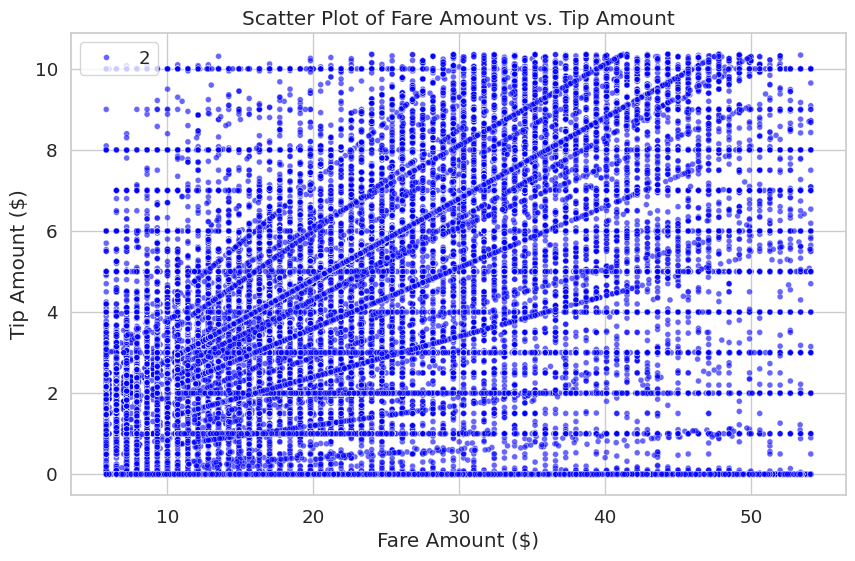

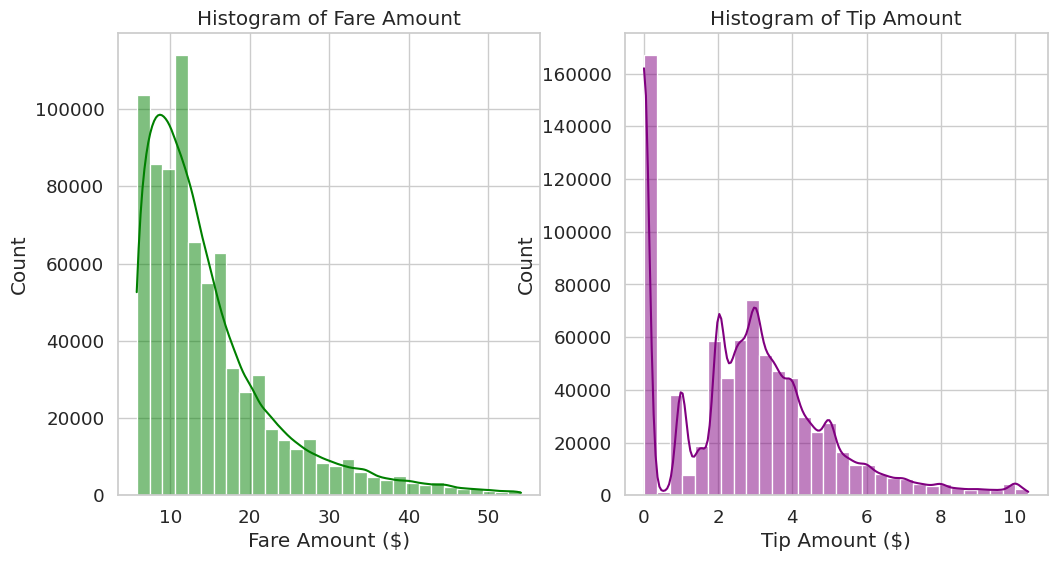

In [51]:
# Boxplot for fare_amount and tip_amount
plt.figure(figsize=(12, 6))

# Scatter plot to observe the relationship between fare amount and tip amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=pandas_df, color='blue', size=2, alpha=0.6)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

# Histograms to view the distributions of fare amount and tip amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pandas_df['fare_amount'], kde=True, bins=30, color='green')
plt.title('Histogram of Fare Amount')
plt.xlabel('Fare Amount ($)')

plt.subplot(1, 2, 2)
sns.histplot(pandas_df['tip_amount'], kde=True, bins=30, color='purple')
plt.title('Histogram of Tip Amount')
plt.xlabel('Tip Amount ($)')
plt.show()

In [52]:
# Filter for negative fares and tips, group by payment type
negative_fares_tips = df.filter((col("fare_amount") < 0) | (col("tip_amount") < 0))

In [53]:
negative_fares_tips.groupBy("payment_type").count().show()

+------------+-----+
|payment_type|count|
+------------+-----+
|           0|  130|
|           1|   38|
|           3| 9171|
|           2|11373|
|           4|29110|
+------------+-----+



In [54]:
# Group by RateCodeID for entries with negative fares or tips
negative_fares_tips.groupBy("RateCodeID").count().show()

+----------+-----+
|RateCodeID|count|
+----------+-----+
|      NULL|  130|
|       1.0|44829|
|       4.0|  143|
|       3.0|  572|
|       2.0| 3341|
|       5.0|  807|
+----------+-----+



In [55]:
# Extract year and month, then analyze counts of negative values
negative_fares_tips.withColumn("year", year("tpep_pickup_datetime")) \
    .withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("year", "month").count().orderBy("year", "month").show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2023|    1|25052|
|2023|    2|24770|
+----+-----+-----+



## 2. Trip Duration vs. Distance

In [56]:
# #Collect duration data
# time_difference_seconds = sampled_df.withColumn("time_difference_seconds",
#                    (col("tpep_dropoff_datetime") - col("tpep_pickup_datetime"))).collect()
                   
# time_difference_seconds_values = [row.time_difference_seconds.total_seconds() for row in time_difference_seconds]

# #Collect trip distance data
# trip_distance = sampled_df.select("trip_distance").collect()
# trip_distance_values = [row[0] for row in trip_distance]

In [238]:
# Calculate the time difference in seconds using unix_timestamp
filtered_df = sampled_df.withColumn(
    "trip_duration_seconds",
    unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))
)

# filter using quantile range function based on time_difference_seconds
filtered_df = filter_quantile_range(filtered_df, ["trip_duration_seconds", "trip_distance"], 0.05, 0.95)

In [239]:
pandas_df = filtered_df.select("trip_duration_seconds", "trip_distance").toPandas()


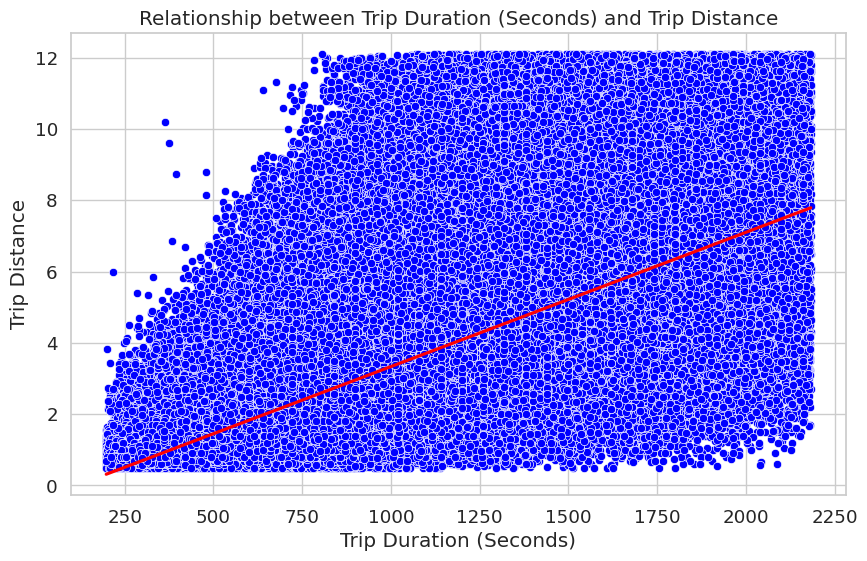

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, color='blue')
sns.regplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, scatter=False, color='red', ci=None)
plt.title("Relationship between Trip Duration (Seconds) and Trip Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()


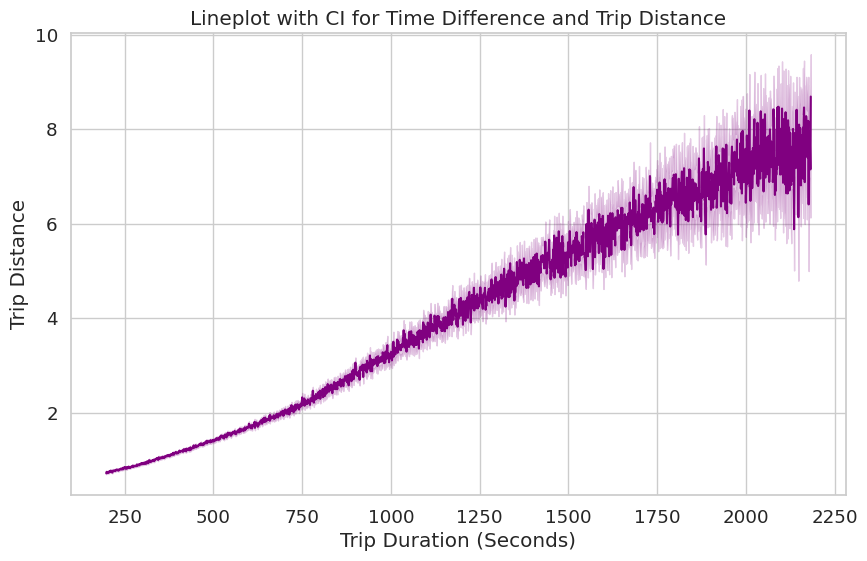

In [244]:
# Harin - Lineplot with confidence Intervals

plt.figure(figsize=(10, 6))
sns.lineplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, color='purple')
plt.title("Lineplot with CI for Time Difference and Trip Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()

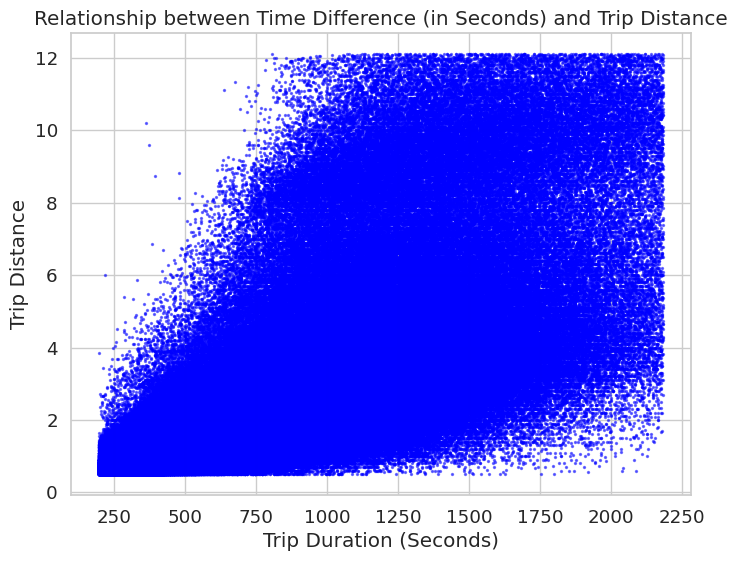

In [59]:
#X/Y plot
plt.figure(figsize=(8, 6))
plt.scatter(x = "trip_duration_seconds", y= "trip_distance", data= pandas_df, color='blue', s=2, alpha=0.5)
plt.title("Relationship between Time Difference (in Seconds) and Trip Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()

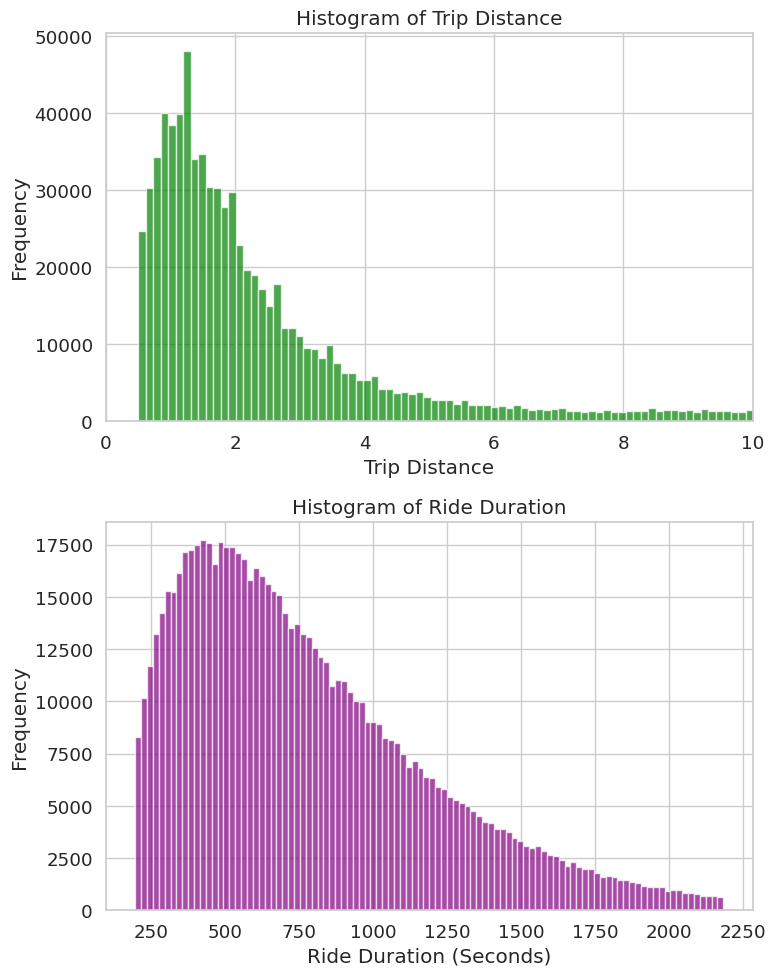

In [60]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Histogram for trip distance
axs[0].hist(pandas_df["trip_distance"], bins=100,  color='green', alpha=0.7)
axs[0].set_title('Histogram of Trip Distance')
axs[0].set_xlabel('Trip Distance')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 10)
axs[0].grid(True)

# Histogram for ride duration
axs[1].hist(pandas_df["trip_duration_seconds"], bins=100, color='purple', alpha=0.7)
axs[1].set_title('Histogram of Ride Duration')
axs[1].set_xlabel('Ride Duration (Seconds)')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 3. Trends by hour of day

In [61]:
sampled_df_time = sampled_df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
sampled_df_time = sampled_df_time.withColumn("year", year("tpep_pickup_datetime")) \
       .withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day", dayofmonth("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime")) \
       .withColumn("minute", minute("tpep_pickup_datetime")) \
       .withColumn("second", second("tpep_pickup_datetime"))

sampled_df_time.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+---+----+------+------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|year|month|day|hour|minute|second|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+---+----+------+------+
|       2| 2023-01-01 00:55:08|  2023-01-01 01:01:27|            1.0|          1.1|  

In [62]:
pandas_time_df = sampled_df_time.select("year","month","day","hour","minute","second","Extra","fare_amount", "trip_distance").toPandas()
pandas_time_df['Amount_per_Distance'] = pandas_time_df["fare_amount"]/pandas_time_df["trip_distance"]
pandas_time_df

,year,month,day,hour,minute,second,Extra,fare_amount,trip_distance,Amount_per_Distance
0,2023,1,1,0,55,8,1.0,7.90,1.10,7.181818
1,2023,1,1,0,13,4,1.0,10.00,1.52,6.578947
2,2023,1,1,0,45,11,1.0,19.80,2.23,8.878924
3,2023,1,1,0,40,13,3.5,5.10,0.70,7.285714
4,2023,1,1,0,31,30,3.5,19.10,4.10,4.658537
...,...,...,...,...,...,...,...,...,...,...
897753,2023,2,28,23,51,0,0.0,20.76,4.69,4.426439
897754,2023,2,28,23,46,55,0.0,13.91,2.38,5.844538
897755,2023,2,28,23,7,46,0.0,34.53,10.48,3.294847
897756,2023,2,28,23,41,22,0.0,20.03,4.71,4.252654


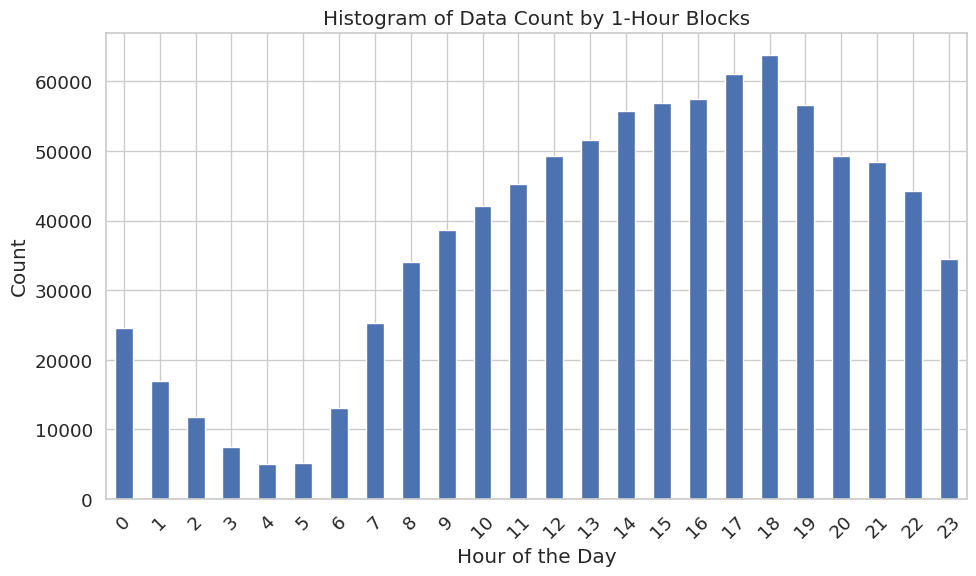

In [63]:
time_block_counts = pandas_time_df.groupby('hour').size()

plt.figure(figsize=(10, 6))
time_block_counts.plot(kind='bar')
plt.title('Histogram of Data Count by 1-Hour Blocks')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

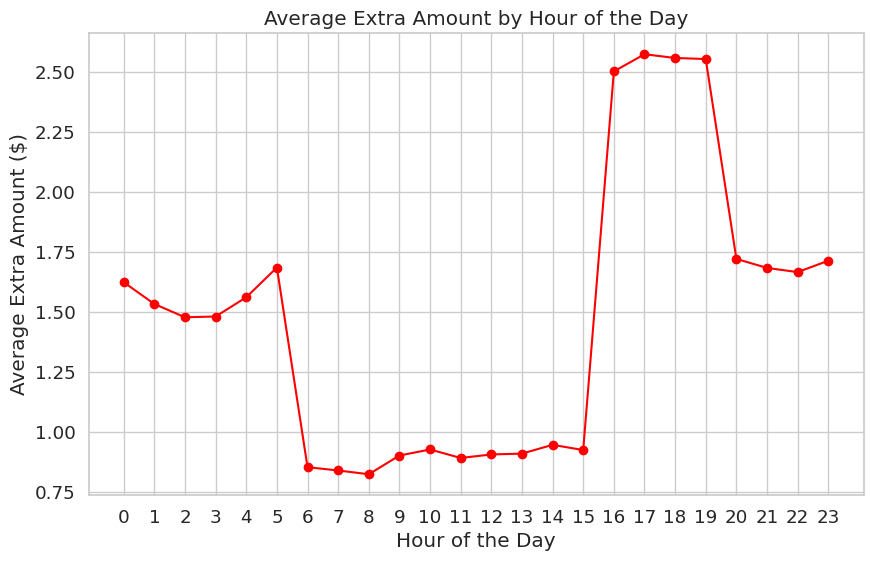

In [64]:
hourly_avg = pandas_time_df.groupby('hour')['Extra'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='red')
plt.title('Average Extra Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Extra Amount ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

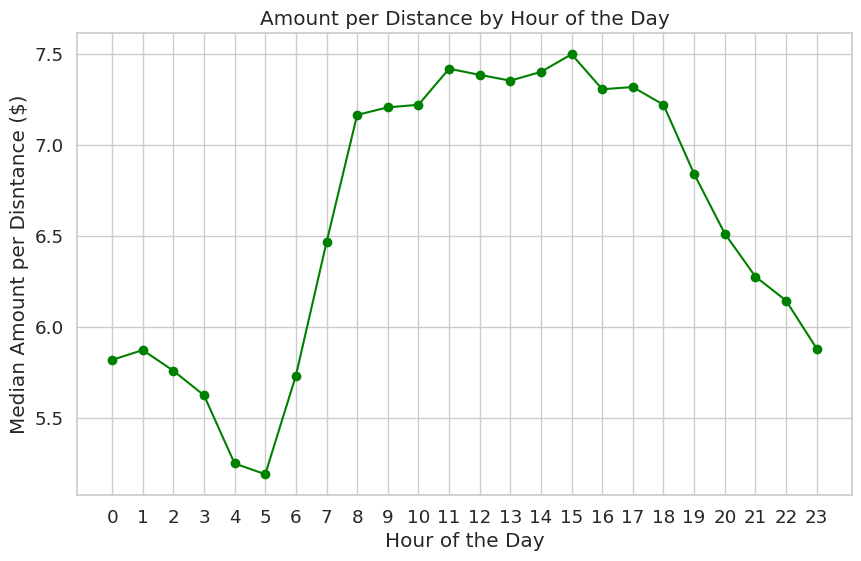

In [65]:
avg = pandas_time_df.groupby('hour')['Amount_per_Distance'].median()

plt.figure(figsize=(10, 6))
plt.plot(avg.index, avg.values, marker='o', color='green')
plt.title('Amount per Distance by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Median Amount per Disntance ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## 4. Distribution of Payment Type by Locations & Months

+------------+------------+------+
|PULocationID|payment_type| count|
+------------+------------+------+
|         236|           1|216604|
|         175|           2|     6|
|         255|           3|    26|
|         195|           4|     2|
|           3|           0|     3|
|         256|           4|    34|
|          95|           2|   222|
|         146|           0|   190|
|         212|           1|    72|
|          80|           3|    23|
|         256|           1|  1050|
|         136|           1|   210|
|         214|           3|     1|
|         253|           2|     5|
|         243|           4|    20|
|          44|           3|     5|
|          88|           0|   488|
|         226|           2|  1631|
|          39|           3|    15|
|         139|           2|    16|
+------------+------------+------+
only showing top 20 rows

+------------+------------+------+
|DOLocationID|payment_type| count|
+------------+------------+------+
|         236|           1|23

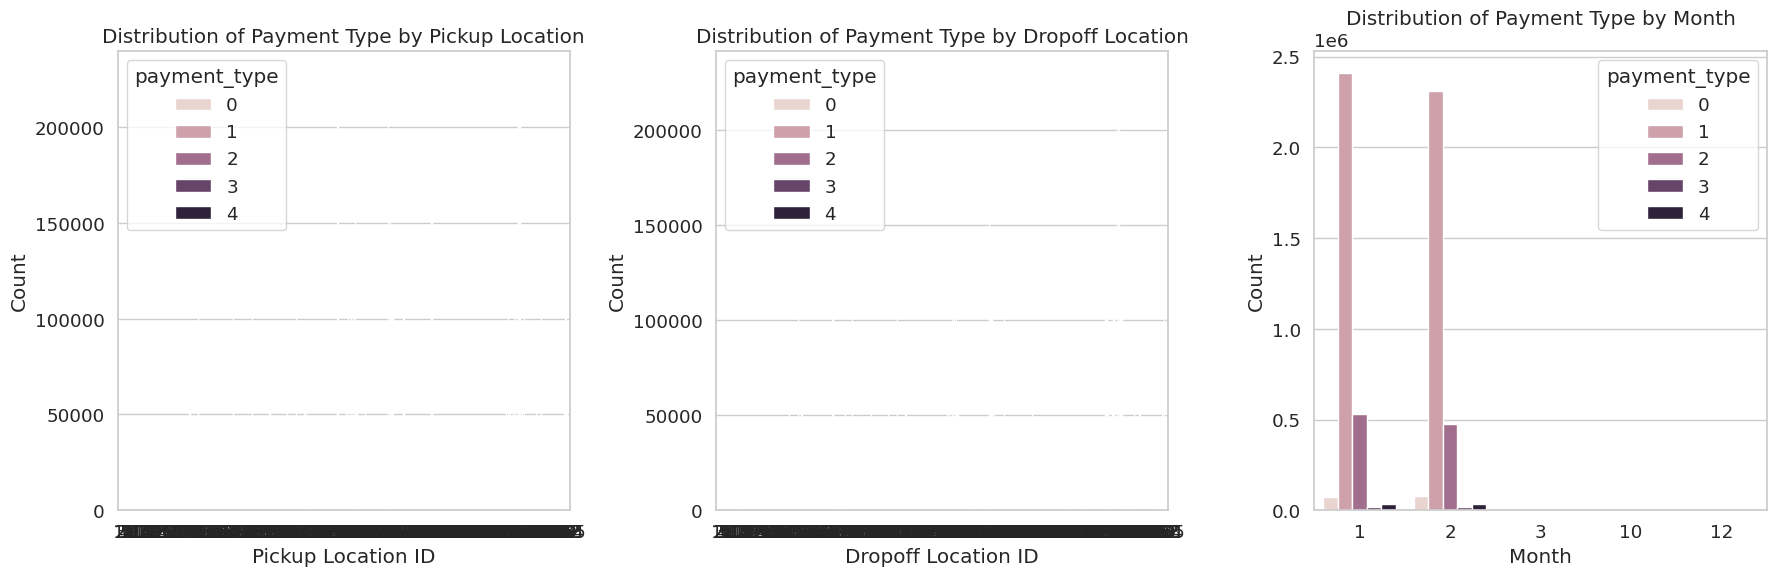

In [66]:
# Distribution of Payment_type by Pickup Location
pickup_location_distribution = df.groupBy("PULocationID", "payment_type").count()

# Distribution of Payment_type by Dropoff Location
dropoff_location_distribution = df.groupBy("DOLocationID", "payment_type").count()

# Distribution of Payment_type by Month
month_distribution = df.withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("month", "payment_type").count()

# Show the distributions
pickup_location_distribution.show()
dropoff_location_distribution.show()
month_distribution.show()

# Plotting the distributions
plt.figure(figsize=(18, 6))

# Distribution by Pickup Location
plt.subplot(1, 3, 1)
sns.barplot(x="PULocationID", y="count", hue="payment_type", data=pickup_location_distribution.toPandas())
plt.title('Distribution of Payment Type by Pickup Location')
plt.xlabel('Pickup Location ID')
plt.ylabel('Count')

# Distribution by Dropoff Location
plt.subplot(1, 3, 2)
sns.barplot(x="DOLocationID", y="count", hue="payment_type", data=dropoff_location_distribution.toPandas())
plt.title('Distribution of Payment Type by Dropoff Location')
plt.xlabel('Dropoff Location ID')
plt.ylabel('Count')

# Distribution by Month
plt.subplot(1, 3, 3)
sns.barplot(x="month", y="count", hue="payment_type", data=month_distribution.toPandas())
plt.title('Distribution of Payment Type by Month')
plt.xlabel('Month')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [259]:
df.withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("month").count().show()

+-----+-------+
|month|  count|
+-----+-------+
|   12|     31|
|    1|3066727|
|   10|     11|
|    2|2913910|
|    3|     42|
+-----+-------+



In [262]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: double, trip_distance: double, RatecodeID: double, store_and_fwd_flag: string, PULocationID: bigint, DOLocationID: bigint, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, airport_fee: double]

# Top 10 pickup locations & map

In [267]:
locdf = df.select('PULocationID','DOLocationID').cache()

In [290]:
pudf = locdf.groupby('PULocationID').count().orderBy('count', ascending = False)

In [291]:
dodf = locdf.groupby('DOLocationID').count().orderBy('count', ascending = False)

In [292]:
loc = pd.read_csv('hradhakrishnan/yellow_taxi_data/taxi_zone_lookup.csv')

In [288]:
import pyspark.pandas as ps
from pyspark.sql import functions as F


In [293]:
merged_loc = pudf.join(loc, F.col("pudf.PULocationID") == F.col("loc.LocationID"))


AttributeError: 'DataFrame' object has no attribute '_jdf'

In [287]:
merged = pudf.merge(loc, left_on='lkey', right_on='rkey')

AttributeError: 'DataFrame' object has no attribute 'merge'

In [285]:
loc =ps.DataFrame(loc)

In [286]:
df = ps.DataFrame(df)

AssertionError: [InternalField(dtype=int32, struct_field=StructField('VendorID', IntegerType(), True)), InternalField(dtype=datetime64[us], struct_field=StructField('tpep_pickup_datetime', TimestampNTZType(), True)), InternalField(dtype=datetime64[us], struct_field=StructField('tpep_dropoff_datetime', TimestampNTZType(), True)), InternalField(dtype=float64, struct_field=StructField('passenger_count', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('trip_distance', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('RatecodeID', DoubleType(), True)), InternalField(dtype=object, struct_field=StructField('store_and_fwd_flag', StringType(), True)), InternalField(dtype=int64, struct_field=StructField('PULocationID', LongType(), True)), InternalField(dtype=int64, struct_field=StructField('DOLocationID', LongType(), True)), InternalField(dtype=int64, struct_field=StructField('payment_type', LongType(), True)), InternalField(dtype=float64, struct_field=StructField('fare_amount', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('extra', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('mta_tax', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('tip_amount', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('tolls_amount', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('improvement_surcharge', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('total_amount', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('congestion_surcharge', DoubleType(), True)), InternalField(dtype=float64, struct_field=StructField('airport_fee', DoubleType(), True))]

In [275]:
loc

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN
